Exploring various programming methods (see day 3)

In [32]:
import pandas as pd
import pandas.testing as pdt
import numpy as np
import lcanalyzer.models as models
from lcanalyzer import survey, plots
from functools import reduce
import time
import collections.abc

### Define Parameters

In [2]:
# Define the bands names
bands = 'ugrizy'

# Mag column
mag_col = 'psfMag'

# Time column
time_col = 'expMidptMJD'

### Load in data

In [3]:
lc_datasets = {}
lc_datasets['lsst'] = pd.read_pickle('data/lsst_RRLyr.pkl')

In [4]:
# Create an empty list where we will be storing our light curves
lcs = []
# For each observed object
for obj_id in lc_datasets["lsst"]["objectId"].unique():
    # Create an empty dict for the light curves of this object
    lc = {}
    lc['objectId'] = obj_id
    for b in bands:
        filt_band_obj = (lc_datasets["lsst"]["objectId"] == obj_id) & (
            lc_datasets["lsst"]["band"] == b
        )
        # The observations in each band are converted to lists and stored as dict elements
        lc[b+'_'+mag_col] = np.array(lc_datasets["lsst"][filt_band_obj][mag_col])
        lc[b+'_'+time_col] = np.array(lc_datasets["lsst"][filt_band_obj][time_col])
    lcs.append(lc)
# Turn the list of dicts into a DataFrame    
lcs = pd.DataFrame.from_records(lcs)

### Process Nans

In [5]:
def lightcurve_nans2zero(lcs, bands):
    for b in bands:
        lcs['cleaned_{}_psfMag'.format(b)] = lcs['{}_psfMag'.format(b)].map(lambda x: np.where(np.isnan(x),0,x))
    return lcs

In [6]:
def lightcurve_remove_nans(lcs, bands):
    for b in bands:
        lcs['removed_nans_{}_psfMag'.format(b)] = lcs['{}_psfMag'.format(b)].map(lambda x: np.delete(x, np.where(np.isnan(x))))
        lcs['removed_nans_{}_expMidptMJD'.format(b)] = lcs['{}_psfMag'.format(b)].map(lambda x: np.delete(x, np.where(np.isnan(x))))
    return lcs

In [7]:
lcs_nan2zero = lightcurve_nans2zero(lcs, bands)

In [8]:
lcs_removed_nans = lightcurve_remove_nans(lcs, bands)

In [9]:
def lightcurve_remove_nans_instructor_solution(lcs,bands, mag_col, time_col):
    for b in bands:
        # Create column names variables for better readability
        mcol = b + "_" + mag_col
        tcol = b + "_" + time_col
        mcol_cl = mcol + "_cleaned"
        tcol_cl = tcol + "_cleaned"
        # The new cleaned columns, `mcol_cl` and `tcol_cl`, contain the result of applying
        # a lambda function to each row (`axis=1` argument). The lambda function returns a tuple
        # of two numpy arrays, filtered according to the mask that is `False` for the elements that
        # are NaNs and `True` to all other elements.
        lcs[[mcol_cl, tcol_cl]] = lcs.apply(
            lambda l: (
                l[mcol][~np.isnan(l[mcol])],
                l[tcol][~np.isnan(l[mcol])],
            ),
            axis=1,
            result_type="expand",
        )
    return lcs

In [10]:
print(len(lcs_removed_nans['u_psfMag'][0]))
print(len(lcs_removed_nans['u_expMidptMJD'][0]))
print(len(lcs_removed_nans['cleaned_u_psfMag'][0]))
print(len(lcs_removed_nans['removed_nans_u_psfMag'][0]))
print(len(lcs_removed_nans['removed_nans_u_expMidptMJD'][0]))


39
39
39
24
24


### Practice Reduce

In [11]:
sequence = np.arange(1, 5)

In [12]:
reduce((lambda a, b : a + b), sequence)

10

### Time performance decorator

In [13]:
def time_performance(func):
    
    def inner(*args, **kwargs):
        start = time.process_time_ns()
        result = func(*args, **kwargs)
        time_took = (time.process_time_ns() - start)/1e9
        
        print("Took {} seconds".format(time_took))
        return result
        
    return inner

In [14]:
@time_performance
def measure_me(n):
    total = 0
    for i in range(n):
        total += i * i

    return total

In [15]:

measure_me(10)

Took 3.2e-05 seconds


285

In [16]:
class Variable:
    """A Variable class"""
    def __init__(self, obj_id):
        self.obj_id = obj_id
        self.lc = {
                   'mjd': np.array([]),
                   'mag': np.array([])
                  }

    def __str__(self):
      return str(self.obj_id)

    def add_observations(self, mjds, mags, mag_errs=None):
        """
        Adds observations to the light curve.
    
        Args:
          mjds: A vector of Modified Julian Dates (x values).
          mags: A vector of luminosities (y values).
        """

        self.convert_to_array(mjds)
        self.convert_to_array(mags)
        
        observation_arrays = [mjds, mags]
        
        self.lc['mjd'] = np.array(mjds)
        self.lc['mag'] = np.array(mags)
        if mag_errs is not None:
            self.convert_to_array(mag_errs)
            observation_arrays.append(mag_errs)
            self.lc['mag_errs'] = np.array(mag_errs)

        self.compare_len(observation_arrays)

        return

    def __len__(self):
        """
        Returns length of lightcurve
        """
        return len(self.lc['mjd'])


    def convert_to_array(self, var):
        if not isinstance(var, np.ndarray):
            if isinstance(var, (list, tuple, pd.Series)):
                var = np.array(var)
            elif isinstance(var, (int, float)):
                var = np.array([var])
            else:
               raise ValueError("Data must be array-like, int, or float")

        return var

    def compare_len(self, arrays):
        for array in arrays:
            if len(array) != self.__len__():
                raise Exception("All observational arrays must have the same length")
                
    @property
    def mean_mag(self):
        return np.mean(self.lc['mags'])

In [17]:
obj_id = lc_datasets['lsst']['objectId'].unique()[7]
b = 'g'
filt_band_obj = (lc_datasets['lsst']['objectId'] == obj_id) & (
        lc_datasets['lsst']['band'] == b
    )
obj_obs = lc_datasets['lsst'][filt_band_obj]
star = Variable(obj_id)
star.add_observations(obj_obs[time_col],obj_obs[mag_col])
print(star.__len__())

44


In [18]:
star.compare_len([star.lc['mjd'], star.lc['mag']])

In [19]:
isinstance(obj_obs[mag_col], pd.core.series.Series)

True

### Practicing Object Oriented Programming

In [27]:
survey_test = survey.Survey('data/lsst_RRLyr.pkl')

In [30]:
lc = survey_test.get_lc(1251384969897480052, 'u')

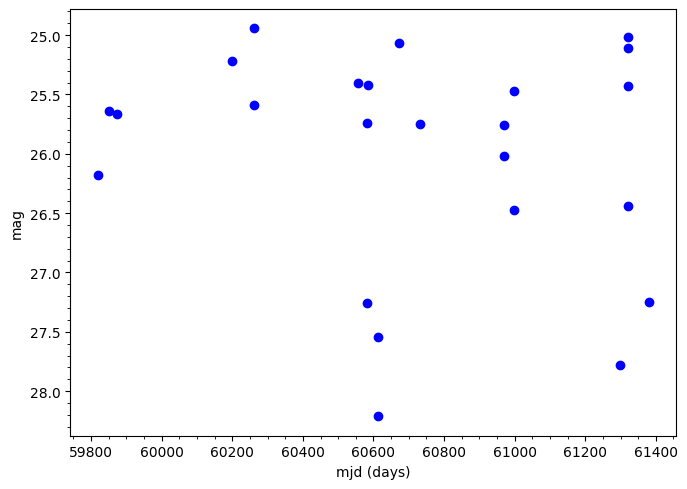

In [35]:
plots.plot_lightcurve(lc['mjd'], lc['mag'])